# Supervised learning portion

In [1]:
# importing packages
import pandas as pd
import numpy as np
import sys
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
import ipywidgets as widgets
from IPython.display import display
from geopy.geocoders import Nominatim
import pycountry_convert as pc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

# importing fuctions we created
sys.path.append("/Users/arturoavila/Documents/Milestone II Project/spotify-market-popularity/functions")
from feature_engineering import *

In [2]:
# Paths to JSON files to extract data
audio_path, artists_path, playlists_path = (
    r"../../data/spotify_audio_features.json",
    r"../../data/spotify_artists.json",
    r"../../data/spotify_top_50_playlists.json",
)

In [3]:
# Function that takes the JSON files and returns the artist and tracks dfs
artists, tracks = get_data(audio_path, artists_path, playlists_path)
display(artists.head())
display(tracks.head())

,artist_id,artist_name,followers,genres,popularity,parent_genre
0,1Kjs5u8GQf6zCFdTj6SI9E,Malik Montana,1038436,"[polish drill, polish hip hop, polish trap]",64,NaN
1,2CKOmarVWvWqkNWUatHCex,Ana Castela,2932225,"[agronejo, funk rj, sertanejo pop]",82,Country
2,7krakxeyEmge6pzTthKNyg,Bausa,8035,[russelater],52,Electronic
3,66RfYVdftqnuHRicyClgL0,Dharius,2313917,[mexican hip hop],69,Hip Hop
4,29zSTMejPhY0m7kwNQ9SPI,Lola Amour,709383,[opm],67,Pop


,track_id,track_name,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,37i9dQZEVXbNG2KDcFcKOF,single,54dZypaXHAIDzBe9ujAZ63,[{'id': '5cj0lLjcoR7YOSnhnX0Po5'}],True,100,global,183,...,-8.603,1,0.174,0.269,0.000003,0.0901,0.732,99.968,231750,4
1,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,37i9dQZEVXbK4fwx2r07XW,single,54dZypaXHAIDzBe9ujAZ63,[{'id': '5cj0lLjcoR7YOSnhnX0Po5'}],True,100,australia,183,...,-8.603,1,0.174,0.269,0.000003,0.0901,0.732,99.968,231750,4
2,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,37i9dQZEVXbM1EaZ0igDlz,single,54dZypaXHAIDzBe9ujAZ63,[{'id': '5cj0lLjcoR7YOSnhnX0Po5'}],True,100,austria,183,...,-8.603,1,0.174,0.269,0.000003,0.0901,0.732,99.968,231750,4
3,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,37i9dQZEVXbLRLeF2cVSaP,single,54dZypaXHAIDzBe9ujAZ63,[{'id': '5cj0lLjcoR7YOSnhnX0Po5'}],True,100,belarus,183,...,-8.603,1,0.174,0.269,0.000003,0.0901,0.732,99.968,231750,4
4,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,37i9dQZEVXbND4ZYa46PaA,single,54dZypaXHAIDzBe9ujAZ63,[{'id': '5cj0lLjcoR7YOSnhnX0Po5'}],True,100,belgium,183,...,-8.603,1,0.174,0.269,0.000003,0.0901,0.732,99.968,231750,4


In [4]:
# Creaing plot to analyze the different potential features
def update_plot(column):
    plt.figure(figsize=(8, 4))
    sns.countplot(data=tracks, x=column)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()


column_dropdown = widgets.Dropdown(options=tracks.columns, description="Select a Column:")

In [5]:
# Plot to analyze features
interactive_plot = widgets.interactive(update_plot, column=column_dropdown)
display(interactive_plot)

interactive(children=(Dropdown(description='Select a Column:', options=('track_id', 'track_name', 'playlist_id…

In [6]:
# Describing the different columns to understand what they are and their spread
tracks.describe()

,track_popularity,num_avail_markets,num_artists,playlist_rank,tot_artist_followers,avg_artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,2899.000000,2899.000000,2899.000000,2899.000000,2.899000e+03,2899.000000,2899.00000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000,2899.000000
mean,77.320455,179.904450,1.584339,25.492929,1.398940e+07,71.791396,0.68141,0.649504,5.483270,-6.644587,0.517765,0.101765,0.289506,0.017762,0.170086,0.534856,123.218677,193061.846499,3.916868
std,13.598239,23.681363,0.964184,14.430823,2.452359e+07,14.495052,0.13586,0.165477,3.562609,2.519374,0.499771,0.092185,0.253406,0.095588,0.124837,0.219624,28.177949,48609.939998,0.397961
min,25.000000,1.000000,1.000000,1.000000,4.600000e+01,28.000000,0.22200,0.034900,0.000000,-18.875000,0.000000,0.023200,0.000028,0.000000,0.023100,0.036400,59.157000,61673.000000,1.000000
25%,65.000000,183.000000,1.000000,13.000000,3.932020e+05,60.000000,0.58600,0.538000,2.000000,-8.067000,0.000000,0.040800,0.083700,0.000000,0.094300,0.369000,99.968000,161240.000000,4.000000
50%,80.000000,184.000000,1.000000,25.000000,2.834583e+06,74.000000,0.69100,0.673000,6.000000,-6.287000,1.000000,0.060600,0.213000,0.000002,0.117000,0.540000,123.926000,187027.000000,4.000000
75%,89.000000,184.000000,2.000000,38.000000,1.483963e+07,84.000000,0.79000,0.770000,9.000000,-4.930000,1.000000,0.132000,0.464500,0.000090,0.213000,0.718500,141.095000,219724.000000,4.000000
max,100.000000,184.000000,15.000000,50.000000,1.659658e+08,100.000000,0.97400,0.990000,11.000000,1.155000,1.000000,0.731000,0.981000,0.930000,0.963000,0.978000,209.808000,641941.000000,5.000000


In [7]:
# Creating a columns with the main artist for each son. The other ida in the dictionary represent the featured artist
tracks["artist_id"] = tracks["artist_ids"].apply(lambda x: x[0]["id"] if (x and "id" in x[0]) else None)

In [8]:
# Confirming that the first id is for the first artist
tracks.loc[tracks["artist_id"] == "6DARBhWbfcS9E4yJzcliqQ"]

,track_id,track_name,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_id
1824,0YQJoDL6f46J0n1rOVkpxJ,Softly,37i9dQZEVXbMWDif5SCBJq,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,77,india,183,...,1,0.2040,0.1910,0.0,0.0791,0.902,92.986,155161,4,6DARBhWbfcS9E4yJzcliqQ
1836,6ygiy70ujkNOYXM1tQuMNe,Admirin' You (feat. Preston Pablo),37i9dQZEVXbMWDif5SCBJq,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,73,india,183,...,1,0.0851,0.0935,0.0,0.1040,0.675,96.018,214750,4,6DARBhWbfcS9E4yJzcliqQ
1860,1Er6TEtbyuW1b9QtBVkggD,Jee Ni Lagda,37i9dQZEVXbMWDif5SCBJq,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,76,india,183,...,0,0.1920,0.3380,0.0,0.1300,0.907,93.005,139355,4,6DARBhWbfcS9E4yJzcliqQ
2350,2uWZ7EGddFlA1DJ3Rzzvs2,Bachke Bachke (feat. Yarah),37i9dQZEVXbNy9tB5elXf1,album,3BGU0BqGwBkYDHpfCWFm7I,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq...",False,77,pakistan,183,...,0,0.0861,0.3940,0.0,0.3930,0.461,88.086,210118,4,6DARBhWbfcS9E4yJzcliqQ


In [9]:
# Merging the two DFs
df = artists.merge(tracks, on="artist_id")

df.columns

Index(['artist_id', 'artist_name', 'followers', 'genres', 'popularity',
       'parent_genre', 'track_id', 'track_name', 'playlist_id', 'album_type',
       'album_id', 'artist_ids', 'explicit', 'track_popularity', 'market_id',
       'num_avail_markets', 'num_artists', 'playlist_rank',
       'tot_artist_followers', 'avg_artist_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')

In [10]:
# Figuring out which of the song features are are categorical
df[
    [
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
        "time_signature",
    ]
]

df[["key", "mode", "time_signature"]]

,key,mode,time_signature
0,6,1,4
1,5,1,4
2,3,0,4
3,3,0,4
4,8,0,4
...,...,...,...
2894,11,0,4
2895,8,1,4
2896,8,1,4
2897,5,0,4


In [11]:
# Dropping global to focus on countries
df = df[df["market_id"] != "global"]

In [12]:
# Looking at all the unique countries
df["market_id"].unique()

array(['brazil', 'norway', 'philippines', 'india', 'pakistan',
       'argentina', 'chile', 'peru', 'spain', 'poland', 'panama',
       'nigeria', 'france', 'colombia', 'dominican_republic', 'ecuador',
       'guatemala', 'mexico', 'usa', 'venezuela', 'italy', 'switzerland',
       'taiwan', 'japan', 'vietnam', 'thailand', 'germany', 'belarus',
       'romania', 'ukraine', 'morocco', 'singapore', 'saudi_arabia',
       'denmark', 'sweden', 'indonesia', 'czech_republic', 'egypt',
       'malaysia', 'slovakia', 'hong_kong', 'israel', 'austria',
       'kazakhstan', 'finland', 'south_korea', 'belgium', 'australia',
       'ireland', 'netherlands', 'uae', 'united_kingdom', 'new_zealand',
       'turkey', 'south_africa', 'canada', 'hungary'], dtype=object)

In [13]:
# Testing whether the first id on artist_id is the main artist
feats = df[df["track_name"].str.contains("feat")]
feats[["track_name", "artist_name", "artist_id", "artist_ids"]]

,track_name,artist_name,artist_id,artist_ids
7,Admirin' You (feat. Preston Pablo),Karan Aujla,6DARBhWbfcS9E4yJzcliqQ,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq..."
9,Bachke Bachke (feat. Yarah),Karan Aujla,6DARBhWbfcS9E4yJzcliqQ,"[{'id': '6DARBhWbfcS9E4yJzcliqQ'}, {'id': '3nq..."
130,Comforter (feat. Ayra Starr),ElGrandeToto,4BFLElxtBEdsdwGA1kHTsx,"[{'id': '4BFLElxtBEdsdwGA1kHTsx'}, {'id': '3Zp..."
162,"MIRAGE (feat. Ozuna, GIMS & Sfera Ebbasta)",AriBeatz,6cNWiizYLCClZdnIvqU968,"[{'id': '6cNWiizYLCClZdnIvqU968'}, {'id': '1i8..."
193,xoxo (feat. ICEKIID),Artigeardit,6a3WaWgxrVmNIvaiTCI0Kk,"[{'id': '6a3WaWgxrVmNIvaiTCI0Kk'}, {'id': '4Zw..."
...,...,...,...,...
2864,Arranca (feat. Omega),Becky G,4obzFoKoKRHIphyHzJ35G3,"[{'id': '4obzFoKoKRHIphyHzJ35G3'}, {'id': '1Uj..."
2865,Arranca (feat. Omega),Becky G,4obzFoKoKRHIphyHzJ35G3,"[{'id': '4obzFoKoKRHIphyHzJ35G3'}, {'id': '1Uj..."
2866,Arranca (feat. Omega),Becky G,4obzFoKoKRHIphyHzJ35G3,"[{'id': '4obzFoKoKRHIphyHzJ35G3'}, {'id': '1Uj..."
2882,Gangnam Style (feat. DJ Maphorisa & Kabza De S...,Mas Musiq,3fdFRgy3GmfiWQqeKbmFS8,"[{'id': '3fdFRgy3GmfiWQqeKbmFS8'}, {'id': '0oW..."


# Feature Engineering

In [14]:
# Adding the continent features

# cleaned the column first so that the fuction below would recognize the country names
df["market_id"] = df["market_id"].str.replace("_", " ").str.title()
df["market_id"] = df["market_id"].replace("Uae", "United Arab Emirates")
df["market_id"] = df["market_id"].replace("Usa", "United States")


# Create a function to extract the correct continent per country
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name


# Creating the new column
df["continent"] = df["market_id"].apply(country_to_continent)

In [15]:
# Created the featured columns
df["feat"] = df["track_name"].str.contains("feat").astype(int)

In [16]:
df.columns

Index(['artist_id', 'artist_name', 'followers', 'genres', 'popularity',
       'parent_genre', 'track_id', 'track_name', 'playlist_id', 'album_type',
       'album_id', 'artist_ids', 'explicit', 'track_popularity', 'market_id',
       'num_avail_markets', 'num_artists', 'playlist_rank',
       'tot_artist_followers', 'avg_artist_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'continent', 'feat'],
      dtype='object')

# Feature transformation

In [17]:
# Enconding labels for categorical/nomial columns
label_encoders = {}
for column in ["album_type", "continent", "key", "mode", "time_signature", "feat"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [18]:
# Creating the genres features

genre_counts = df["genres"].explode().value_counts()

# Select the top 100 genres
top_genres = genre_counts.head(100).index

# Create a new DataFrame with the top 50 genres and an "Other" category
df_top_genres = df.copy()
df_top_genres["genres"] = df["genres"].apply(lambda x: [genre if genre in top_genres else "Other" for genre in x])

# Use MultiLabelBinarizer to one-hot encode the genres
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df_top_genres["genres"]), columns=mlb.classes_, index=df.index)
df = pd.concat([df_top_genres.drop("genres", axis=1), genres_encoded], axis=1)

In [19]:
len(df.columns)

135

# Feature Selection

In [20]:
# Dropping unnecessary columns
columns_to_drop = [
    "artist_id",
    "artist_name",
    "track_id",
    "track_name",
    "playlist_id",
    "album_id",
    "artist_ids",
    "tot_artist_followers",
    "avg_artist_popularity",
    "parent_genre",
]

df = df.drop(columns=columns_to_drop)

In [21]:
df.head()
# df.to_csv('columns.csv')
len(df.columns)

125

# Baseline model - Logistic Regression Model

In [22]:
lgm = df.copy()

# Features and outcome variable
X = lgm.drop("market_id", axis=1)
y = lgm["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the logistic regression model
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Classification Report for Initial Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the initial model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Initial Model: {accuracy * 100:.2f}%")

Classification Report for Initial Model:
                      precision    recall  f1-score   support

           Argentina       0.50      0.44      0.47         9
           Australia       0.14      0.33      0.20         6
             Austria       0.25      0.08      0.12        13
             Belarus       0.62      0.71      0.67        14
             Belgium       0.00      0.00      0.00        12
              Brazil       0.69      0.90      0.78        10
              Canada       0.00      0.00      0.00        18
               Chile       0.57      0.44      0.50         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.50      0.50      0.50         8
             Denmark       0.88      0.70      0.78        10
  Dominican Republic       0.11      0.25      0.15         4
             Ecuador       0.00      0.00      0.00        12
               Egypt       0.45      0.62      0.53         8
             Finland       0

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
# Calculate accuracy, F1 score, precision, recall, and AUC
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
auc = roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class="ovr")

# Create a dictionary to store the evaluation metrics

metrics_dict = {
    "Model Name": "Baseline Logistic Regression",
    "Accuracy Mean": accuracy,
    "Accuracy Std": 0,
    "F1 Score Mean": f1,
    "F1 Score Std": 0,
}

# Convert the dictionary to a DataFrame
baseline_df = pd.DataFrame([metrics_dict])

# Print the DataFrame
print(baseline_df)

                     Model Name  Accuracy Mean  Accuracy Std  F1 Score Mean  \
0  Baseline Logistic Regression        0.37193             0       0.371055   

   F1 Score Std  
0             0  


## Logistic Regression Model - Improving upon the baseline model

In [37]:
# Define the hyperparameters and their possible values
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    "solver": ["lbfgs", "liblinear"],  # Solver for optimization
    "max_iter": [5000, 10000],  # Maximum number of iterations
}

# Create the logistic regression model
log_reg = LogisticRegression(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_log_reg = LogisticRegression(**best_params)
best_log_reg.fit(X_train, y_train)

# Predict
y_pred = best_log_reg.predict(X_test)

# Evaluate the model
print("Classification Report for Model with Tuned Hyperparameters:")
print(classification_report(y_test, y_pred, zero_division=0))  # Add zero_division parameter

# Calculate accuracy for the tuned model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Model with Tuned Hyperparameters: {accuracy * 100:.2f}%")

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Classification Report for Model with Tuned Hyperparameters:
                      precision    recall  f1-score   support

           Argentina       0.40      0.40      0.40        10
           Australia       0.17      0.10      0.12        10
             Austria       0.00      0.00      0.00        10
             Belarus       0.56      0.50      0.53        10
             Belgium       0.00      0.00      0.00        10
              Brazil       0.90      0.90      0.90        10
              Canada       0.06      0.10      0.07        10
               Chile       0.86      0.60      0.71        10
            Colombia       0.17      0.20      0.18        10
      Czech Republic       0.55      0.60      0.57        10
             Denmark       1.00      0.40      0.57        10
  Dominican Republic       0.11      0.10      0.11        10
             Ecuador       0.07      0.10      0.08        10
               Egypt       0.89      0.80      0.84        10
         

In [38]:
# Getting CV Scores
best_log_reg = LogisticRegression(**best_params)
accuracy_scores = cross_val_score(best_log_reg, X_train, y_train, cv=5, scoring="accuracy")
f1_scores = cross_val_score(best_log_reg, X_train, y_train, cv=5, scoring="f1_weighted")

mean_accuracy_score = accuracy_scores.mean()
std_accuracy_score = accuracy_scores.std()
mean_f1_score = f1_scores.mean()
std_f1_score = f1_scores.std()

lg_dict = {
    "Model Name": "Tuned Logistic Regression",
    "Accuracy Mean": mean_accuracy_score,
    "Accuracy Std": std_accuracy_score,
    "F1 Score Mean": mean_f1_score,
    "F1 Score Std": std_f1_score,
}

lg_df = pd.DataFrame([lg_dict])

# Print the DataFrame
print(lg_df)

                  Model Name  Accuracy Mean  Accuracy Std  F1 Score Mean  \
0  Tuned Logistic Regression       0.375149      0.017902       0.376274   

   F1 Score Std  
0      0.010265  


# Testing Multiple methods

# Ensemble Learning Models
## Gradient Boost (Boosting)

In [26]:
gb = df.copy()
gb.fillna(value=0, inplace=True)
X = gb.drop("market_id", axis=1)
y = gb["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the GradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predict
y_pred = gb_model.predict(X_test)

# Evaluate the model
print("Classification Report for Gradient Boosting Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the Gradient Boosting model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Gradient Boosting Model: {accuracy * 100:.2f}%")

Classification Report for Gradient Boosting Model:
                      precision    recall  f1-score   support

           Argentina       0.60      0.67      0.63         9
           Australia       0.17      0.33      0.22         6
             Austria       0.00      0.00      0.00        13
             Belarus       0.67      0.86      0.75        14
             Belgium       0.00      0.00      0.00        12
              Brazil       1.00      0.70      0.82        10
              Canada       0.25      0.17      0.20        18
               Chile       0.71      0.56      0.63         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.18      0.25      0.21         8
             Denmark       0.58      0.70      0.64        10
  Dominican Republic       0.00      0.00      0.00         4
             Ecuador       0.08      0.08      0.08        12
               Egypt       0.58      0.88      0.70         8
             Finla

## Gradient Boost Hyperparameter Tuning, Regularization, and Cross-validation

In [27]:
# Before reducing the number of genres, the grid search was taking a long time so a pipeline was used
# to improve it's performance. At its current iteration, the pipeline doesn't make much of a difference
# in terms of speed

# Create a pipeline with preprocessing and GradientBoostingClassifier
gb_pipeline = Pipeline([("classifier", GradientBoostingClassifier(random_state=42))])

# Define the hyperparameters and their possible values
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3],
    "classifier__learning_rate": [0.01],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(gb_pipeline, param_grid, cv=5, n_jobs=-1, scoring="accuracy")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_gb_model = grid_search.best_estimator_

# Predict
y_pred = best_gb_model.predict(X_test)

# Evaluate the model
print("Classification Report for Tuned Gradient Boosting Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the tuned model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Tuned Gradient Boosting Model: {accuracy * 100:.2f}%")

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Classification Report for Tuned Gradient Boosting Model:
                      precision    recall  f1-score   support

           Argentina       0.57      0.44      0.50         9
           Australia       0.31      0.83      0.45         6
             Austria       0.00      0.00      0.00        13
             Belarus       0.65      0.79      0.71        14
             Belgium       0.00      0.00      0.00        12
              Brazil       1.00      0.70      0.82        10
              Canada       0.29      0.11      0.16        18
               Chile       0.62      0.56      0.59         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.40      0.50      0.44         8
             Denmark       1.00      0.70      0.82        10
  Dominican Republic       0.22      0.50      0.31         4
             Ecuador       0.00      0.00      0.00        12
               Egypt       0.62      1.00      0.76         8
            

In [28]:
# Getting CV Scores
accuracy_scores = cross_val_score(best_gb_model, X_train, y_train, cv=5, scoring="accuracy")
f1_scores = cross_val_score(best_gb_model, X_train, y_train, cv=5, scoring="f1_weighted")

mean_accuracy_score = accuracy_scores.mean()
std_accuracy_score = accuracy_scores.std()
mean_f1_score = f1_scores.mean()
std_f1_score = f1_scores.std()

gb_dict = {
    "Model Name": "Tuned Gradient Boost",
    "Accuracy Mean": mean_accuracy_score,
    "Accuracy Std": std_accuracy_score,
    "F1 Score Mean": mean_f1_score,
    "F1 Score Std": std_f1_score,
}

gb_df = pd.DataFrame([gb_dict])

# Print the DataFrame
print(gb_df)

             Model Name  Accuracy Mean  Accuracy Std  F1 Score Mean  \
0  Tuned Gradient Boost       0.403693      0.011932       0.407429   

   F1 Score Std  
0      0.010067  


## Random Forest (Bagging)

In [29]:
rf = df.copy()

X = rf.drop("market_id", axis=1)
y = rf["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Random Forest Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Random Forest Model: {accuracy * 100:.2f}%")

Classification Report for Random Forest Model:
                      precision    recall  f1-score   support

           Argentina       0.83      0.50      0.62        10
           Australia       0.20      0.20      0.20        10
             Austria       0.11      0.10      0.11        10
             Belarus       0.46      0.60      0.52        10
             Belgium       0.00      0.00      0.00        10
              Brazil       0.83      1.00      0.91        10
              Canada       0.08      0.10      0.09        10
               Chile       0.46      0.60      0.52        10
            Colombia       0.25      0.20      0.22        10
      Czech Republic       0.30      0.30      0.30        10
             Denmark       1.00      0.40      0.57        10
  Dominican Republic       0.27      0.30      0.29        10
             Ecuador       0.00      0.00      0.00        10
               Egypt       0.89      0.80      0.84        10
             Finland  

## Random Forest - Hyperparameter Tuning, Regularization, and Cross-validation

In [30]:
# Define the hyperparameters and their possible values for a Random Forest model
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees in the forest
    "max_depth": [None, 10, 20],  # Maximum depth of the trees
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split an internal node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples required to be a leaf node
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, scoring="accuracy")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Tuned Random Forest Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the tuned model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Tuned Random Forest Model: {accuracy * 100:.2f}%")

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Classification Report for Tuned Random Forest Model:
                      precision    recall  f1-score   support

           Argentina       0.60      0.30      0.40        10
           Australia       0.33      0.50      0.40        10
             Austria       0.12      0.10      0.11        10
             Belarus       0.27      0.70      0.39        10
             Belgium       0.00      0.00      0.00        10
              Brazil       0.83      1.00      0.91        10
              Canada       0.09      0.10      0.10        10
               Chile       0.60      0.60      0.60        10
            Colombia       0.14      0.10      0.12        10
      Czech Republic       0.50      0.50      0.50        10
             Denmark       1.00      0.40      0.57        10
  Dominican Republic       0.20      0.30      0.24        10
             Ecuador       0.00      0.00      0.00        10
               Egypt       0.80      0.80      0.80        10
             Fin

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and

In [31]:
# Getting CV Scores
accuracy_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring="accuracy")
f1_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring="f1_weighted")

mean_accuracy_score = accuracy_scores.mean()
std_accuracy_score = accuracy_scores.std()
mean_f1_score = f1_scores.mean()
std_f1_score = f1_scores.std()

rf_dict = {
    "Model Name": "Tuned Random Forest",
    "Accuracy Mean": mean_accuracy_score,
    "Accuracy Std": std_accuracy_score,
    "F1 Score Mean": mean_f1_score,
    "F1 Score Std": std_f1_score,
}

rf_df = pd.DataFrame([rf_dict])

# Print the DataFrame
print(rf_df)

            Model Name  Accuracy Mean  Accuracy Std  F1 Score Mean  \
0  Tuned Random Forest       0.425616      0.015754       0.413133   

   F1 Score Std  
0      0.014937  


# Non-probabilistic
## SVM

In [32]:
svm = df.copy()

# Define the feature columns and the target column
X = svm.drop("market_id", axis=1)
y = svm["market_id"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the SVM model
svm_model = SVC(
    kernel="sigmoid", random_state=42
)  # You can choose different kernels like 'linear', 'poly', 'rbf', or 'sigmoid'

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report for SVM Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the SVM model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of SVM Model: {accuracy * 100:.2f}%")

Classification Report for SVM Model:
                      precision    recall  f1-score   support

           Argentina       0.43      0.60      0.50        10
           Australia       0.33      0.30      0.32        10
             Austria       0.00      0.00      0.00        10
             Belarus       0.80      0.40      0.53        10
             Belgium       0.00      0.00      0.00        10
              Brazil       1.00      0.70      0.82        10
              Canada       0.15      0.40      0.22        10
               Chile       0.86      0.60      0.71        10
            Colombia       0.12      0.20      0.15        10
      Czech Republic       0.67      0.60      0.63        10
             Denmark       1.00      0.40      0.57        10
  Dominican Republic       0.17      0.20      0.18        10
             Ecuador       0.10      0.20      0.13        10
               Egypt       0.83      0.50      0.62        10
             Finland       1.00 

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and

## SVM - Hyperparameter Tuning, Regularization, and Cross-validation

In [33]:
# Define the hyperparameters and their possible values for an SVM model
param_grid = {
    "C": [0.1, 1, 10],  # Regularization parameter
    "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Kernel type
    "gamma": ["scale", "auto", 0.1, 1],  # Kernel coefficient
}

# Create the SVM model
svm_model = SVC(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1, scoring="accuracy")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_svm_model = SVC(**best_params, random_state=42)
best_svm_model.fit(X_train, y_train)

# Predict
y_pred = best_svm_model.predict(X_test)

# Evaluate the model
print("Classification Report for Tuned SVM Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the tuned model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Tuned SVM Model: {accuracy * 100:.2f}%")

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Classification Report for Tuned SVM Model:
                      precision    recall  f1-score   support

           Argentina       0.27      0.30      0.29        10
           Australia       0.60      0.30      0.40        10
             Austria       0.00      0.00      0.00        10
             Belarus       0.38      0.50      0.43        10
             Belgium       0.00      0.00      0.00        10
              Brazil       0.88      0.70      0.78        10
              Canada       0.15      0.30      0.20        10
               Chile       0.60      0.60      0.60        10
            Colombia       0.17      0.10      0.12        10
      Czech Republic       0.45      0.50      0.48        10
             Denmark       1.00      0.40      0.57        10
  Dominican Republic       0.25      0.30      0.27        10
             Ecuador       0.13      0.20      0.16        10
               Egypt       0.64      0.70      0.67        10
             Finland      

In [34]:
# Getting CV Scores
accuracy_scores = cross_val_score(best_svm_model, X_train, y_train, cv=5, scoring="accuracy")
f1_scores = cross_val_score(best_svm_model, X_train, y_train, cv=5, scoring="f1_weighted")

mean_accuracy_score = accuracy_scores.mean()
std_accuracy_score = accuracy_scores.std()
mean_f1_score = f1_scores.mean()
std_f1_score = f1_scores.std()

svm_dict = {
    "Model Name": "Tuned SVM",
    "Accuracy Mean": mean_accuracy_score,
    "Accuracy Std": std_accuracy_score,
    "F1 Score Mean": mean_f1_score,
    "F1 Score Std": std_f1_score,
}

svm_df = pd.DataFrame([svm_dict])

# Print the DataFrame
print(svm_df)

  Model Name  Accuracy Mean  Accuracy Std  F1 Score Mean  F1 Score Std
0  Tuned SVM       0.388318       0.01435       0.396241      0.010797


## Summary Table with Evaluation Metrics for all the models

In [39]:
cv_metrics = pd.concat([baseline_df, lg_df, gb_df, rf_df, svm_df], ignore_index=True)
cv_metrics

,Model Name,Accuracy Mean,Accuracy Std,F1 Score Mean,F1 Score Std
0,Baseline Logistic Regression,0.371930,0.000000,0.371055,0.000000
1,Tuned Logistic Regression,0.375149,0.017902,0.376274,0.010265
2,Tuned Gradient Boost,0.403693,0.011932,0.407429,0.010067
3,Tuned Random Forest,0.425616,0.015754,0.413133,0.014937
4,Tuned SVM,0.388318,0.014350,0.396241,0.010797


# Additional Feature Selection/Engineering with Best Model
#### Given the poor performance, we decided to try additional engineering but none of the methods yield better results

## Most correlated features per country

In [40]:
# Function to get most correlated features per country
def get_country_correlations(merged_df: pd.DataFrame):
    country_list = np.sort(merged_df["market_id"].unique()).tolist()
    # correlation_list = np.sort(corr_variables)
    correlation_dic = {}

    df1 = merged_df.select_dtypes(exclude=["object", "bool"])

    df1 = df1.drop("track_popularity", axis=1)
    corr_variables = df1.columns.tolist()

    corr_var_dic = {"Rank": ["1st", "2nd"]}
    for country in country_list:
        df2 = df1[merged_df["market_id"] == country]
        corr_matrix = get_correlation_matrix(df2, corr_variables)
        corr_matrix = corr_matrix.reset_index()
        # rank_matrix = corr_matrix[corr_matrix["index"] == "playlist_rank"]
        dic = {corr_matrix["index"][i]: corr_matrix["playlist_rank"][i] for i in range(len(corr_matrix))}

        var1 = sorted(dic, key=dic.get)[0]
        var2 = sorted(dic, key=dic.get)[1]

        corr_var_dic[country] = [var1, var2]
        correlation_dic[country] = {var1: dic[var1], var2: dic[var2]}

    top_df = pd.DataFrame.from_dict(corr_var_dic)  # .reset_index().rename(columns= {"index": "rank"})
    top_variables_df = pd.melt(
        top_df,
        id_vars=["Rank"],
        ignore_index=True,
        value_vars=top_df.columns[1:],
        var_name="Country",
        value_name="Top_Variable",
    )
    top_df_final = top_variables_df.pivot_table(columns="Rank", index="Country", values="Top_Variable", aggfunc="first")

    return correlation_dic, top_df_final


def get_correlation_matrix(df, corr_feats: list = None):
    df2 = df.select_dtypes(exclude=["object", "bool"])
    if corr_feats:
        corr_df = df[corr_feats]
    # corr = corr_df.corr()
    else:
        corr_df = df2
    # plt.figure(figsize=(18, 10))
    # sns.heatmap(corr, annot=True)

    return corr_df.corr()

In [41]:
correlation_dic, top_df_final = get_country_correlations(df)

In [42]:
top_df_final.head()

Rank,1st,2nd
Country,,
Argentina,danceability,popularity
Australia,num_avail_markets,album_type
Austria,german pop,alt z
Belarus,followers,key
Belgium,dance pop,gen z singer-songwriter


# Using top n correlated features

In [43]:
# Combine the '1st' and '2nd' columns
combined_features = pd.concat([top_df_final["1st"], top_df_final["2nd"]])

# Get the top 5 most common features
top_n_features = combined_features.value_counts().head(10).index.tolist()

top_n_features

['album_type',
 'key',
 'popularity',
 'num_avail_markets',
 'energy',
 'dance pop',
 'time_signature',
 'duration_ms',
 'feat',
 'valence']

In [44]:
# Running the gradient boost using these features
rf = df.copy()

X = rf[top_n_features]
y = rf["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the GradientBoostingClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Random Forest Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the Gradient Boosting model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Random Forest Model: {accuracy * 100:.2f}%")

Classification Report for Random Forest Model:
                      precision    recall  f1-score   support

           Argentina       0.38      0.33      0.35         9
           Australia       0.00      0.00      0.00         6
             Austria       0.00      0.00      0.00        13
             Belarus       0.43      0.43      0.43        14
             Belgium       0.00      0.00      0.00        12
              Brazil       0.50      0.40      0.44        10
              Canada       0.00      0.00      0.00        18
               Chile       0.25      0.11      0.15         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.15      0.38      0.21         8
             Denmark       0.05      0.10      0.06        10
  Dominican Republic       0.00      0.00      0.00         4
             Ecuador       0.00      0.00      0.00        12
               Egypt       0.00      0.00      0.00         8
             Finland  

# Doing Recursive Feature Engineering (RFE)

In [45]:
# Running RFE on Gradient Boost
# Removing genres to make it more manageable

rfe_df = artists.merge(tracks, on="artist_id")
rfe_df = rfe_df[rfe_df["market_id"] != "global"]

rfe_df["market_id"] = rfe_df["market_id"].str.replace("_", " ").str.title()
rfe_df["market_id"] = rfe_df["market_id"].replace("Uae", "United Arab Emirates")
rfe_df["market_id"] = rfe_df["market_id"].replace("Usa", "United States")

rfe_df["continent"] = rfe_df["market_id"].apply(country_to_continent)
rfe_df["feat"] = rfe_df["track_name"].str.contains("feat").astype(int)

pca_df_no_drop = rfe_df.copy()

columns_to_drop_rfe = ["artist_id", "track_id", "track_name", "playlist_id", "album_id", "artist_ids", "genres"]

rfe_df = rfe_df.drop(columns=columns_to_drop_rfe)

label_encoders = {}
for column in ["artist_name", "album_type", "continent", "key", "mode", "time_signature", "feat", "parent_genre"]:
    le = LabelEncoder()
    rfe_df[column] = le.fit_transform(rfe_df[column])
    label_encoders[column] = le

# genre_counts_rfe = rfe_df['genres'].explode().value_counts()

# # Select the top 50 genres
# top_genres_rfe = genre_counts_rfe.head(100).index

# # Create a new DataFrame with the top 50 genres and an "Other" category
# df_top_genres_rfe = rfe_df.copy()
# df_top_genres_rfe['genres'] = rfe_df['genres'].apply(lambda x: [genre if genre in top_genres_rfe else 'Other' for genre in x])

# # Use MultiLabelBinarizer to one-hot encode the genres
# mlb = MultiLabelBinarizer()
# genres_encoded = pd.DataFrame(mlb.fit_transform(df_top_genres_rfe['genres']), columns=mlb.classes_, index=rfe_df.index)
# rfe_df = pd.concat([df_top_genres_rfe.drop('genres', axis=1), genres_encoded], axis=1)

In [46]:
rfe_df.fillna(value=0, inplace=True)
X = rfe_df.drop("market_id", axis=1)
y = rfe_df["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Selection
model = RandomForestClassifier(random_state=42)

# Apply RFE
# Here, we'll choose the top 10 features. You can adjust this number as desired.
selector = RFE(estimator=model, n_features_to_select=20, step=1)
selector = selector.fit(X_train, y_train)

# Refit the model using only the selected features
X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)
model.fit(X_train_rfe, y_train)

# Evaluation
y_pred = model.predict(X_test_rfe)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using Random Forest Classifier with RFE-selected features: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

# If you want to see which features were selected:
selected_features = pd.Series(selector.support_, index=X.columns)
print("Selected features:")
print(selected_features[selected_features].index.tolist())

Accuracy using Random Forest Classifier with RFE-selected features: 31.58%
                      precision    recall  f1-score   support

           Argentina       0.50      0.44      0.47         9
           Australia       0.08      0.17      0.11         6
             Austria       0.00      0.00      0.00        13
             Belarus       0.50      0.50      0.50        14
             Belgium       0.00      0.00      0.00        12
              Brazil       1.00      0.90      0.95        10
              Canada       0.22      0.11      0.15        18
               Chile       0.50      0.56      0.53         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.15      0.25      0.19         8
             Denmark       0.38      0.50      0.43        10
  Dominican Republic       0.00      0.00      0.00         4
             Ecuador       0.00      0.00      0.00        12
               Egypt       0.75      0.75      0.75     

# Using Top n important features

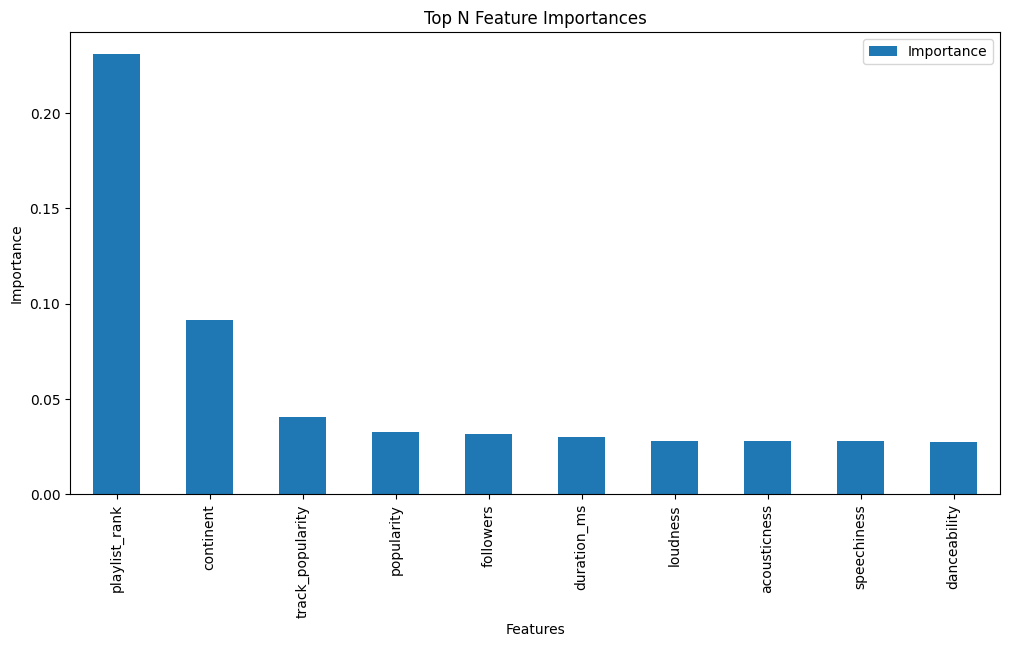

In [47]:
# Doing feature importance for gradient Boost
rf = df.copy()

X = rf.drop("market_id", axis=1)
y = rf["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Extract feature importances
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({"Features": features, "Importance": importances})

# Sort the features based on importance
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Plot the top N features
N = 10  # Change N to display more or fewer features
feature_df.head(N).plot(x="Features", y="Importance", kind="bar", figsize=(12, 6))
plt.title("Top N Feature Importances")
plt.ylabel("Importance")
plt.show()

In [48]:
# Testisg how the number of features changes performance
feature_counts = [5, 10, 15, 20, 25]

for num_features in feature_counts:
    # Get the top 'num_features' features
    top_features = feature_df["Features"].head(num_features).tolist()

    # Filter dataset to use only the top 'num_features' features
    X_top_features = X[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

    # Model Selection and Training
    model_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
    model_top_features.fit(X_train, y_train)

    # Evaluation
    y_pred = model_top_features.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy using Random Forest Classifier with Top {num_features} Features: {accuracy * 100:.2f}%")

Accuracy using Random Forest Classifier with Top 5 Features: 28.25%
Accuracy using Random Forest Classifier with Top 10 Features: 27.89%
Accuracy using Random Forest Classifier with Top 15 Features: 26.67%
Accuracy using Random Forest Classifier with Top 20 Features: 29.65%
Accuracy using Random Forest Classifier with Top 25 Features: 30.53%


## PCA features

In [49]:
# PCA from unsupervised learning
pca_feats = pd.read_csv(
    "/Users/arturoavila/Documents/Milestone II Project/spotify-market-popularity/data/PCA_df_no_genre.csv"
)
pca_feats = pca_feats[["track_id", "PC1", "PC2"]]
pca_feats.dtypes

track_id     object
PC1         float64
PC2         float64
dtype: object

In [50]:
pca_df = artists.merge(tracks, on="artist_id")
pca_df = pca_df[pca_df["market_id"] != "global"]

pca_df["market_id"] = pca_df["market_id"].str.replace("_", " ").str.title()
pca_df["market_id"] = pca_df["market_id"].replace("Uae", "United Arab Emirates")
pca_df["market_id"] = pca_df["market_id"].replace("Usa", "United States")

pca_df["continent"] = pca_df["market_id"].apply(country_to_continent)
pca_df["feat"] = pca_df["track_name"].str.contains("feat").astype(int)

pca_df = pca_df.merge(pca_feats, on="track_id")
pca_df.columns

Index(['artist_id', 'artist_name', 'followers', 'genres', 'popularity',
       'parent_genre', 'track_id', 'track_name', 'playlist_id', 'album_type',
       'album_id', 'artist_ids', 'explicit', 'track_popularity', 'market_id',
       'num_avail_markets', 'num_artists', 'playlist_rank',
       'tot_artist_followers', 'avg_artist_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'continent', 'feat', 'PC1', 'PC2'],
      dtype='object')

In [51]:
columns_to_drop_pca = [
    "artist_id",
    "track_id",
    "track_name",
    "playlist_id",
    "album_id",
    "artist_ids",
    "parent_genre",
    "tot_artist_followers",
    "avg_artist_popularity",
]

pca_df = pca_df.drop(columns=columns_to_drop_pca)

In [52]:
label_encoders = {}
for column in ["artist_name", "album_type", "continent", "key", "mode", "time_signature", "feat"]:
    le = LabelEncoder()
    pca_df[column] = le.fit_transform(pca_df[column])
    label_encoders[column] = le

In [53]:
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(pca_df["genres"]), columns=mlb.classes_, index=pca_df.index)
pca_df = pd.concat([pca_df.drop("genres", axis=1), genres_encoded], axis=1)

In [54]:
pca_df.head()

,artist_name,followers,popularity,album_type,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank,...,vietnamese melodic rap,vietnamese trap,viral afropop,viral pop,west coast rap,yacht rock,yemeni pop,zhenskiy rep,zhongguo feng,zxc
0,66,2932225,82,2,False,87,Brazil,184,1,6,...,0,0,0,0,0,0,0,0,0,0
1,66,2932225,82,2,False,80,Brazil,184,1,34,...,0,0,0,0,0,0,0,0,0,0
2,126,8035,52,2,False,65,Norway,184,1,16,...,0,0,0,0,0,0,0,0,0,0
3,126,8035,52,2,False,62,Norway,184,2,31,...,0,0,0,0,0,0,0,0,0,0
4,519,709383,67,2,False,83,Philippines,183,1,2,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# PCA
pca_df.fillna(value=0, inplace=True)

X = pca_df.drop("market_id", axis=1)

y = pca_df["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the GradientBoostingClassifier
rf_model_pca = RandomForestClassifier(random_state=42)

# Train the model
rf_model_pca.fit(X_train, y_train)

# Predict
y_pred = rf_model_pca.predict(X_test)

# Evaluate the model
print("Classification Report for Gradient Boosting Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the Gradient Boosting model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Gradient Boosting Model: {accuracy * 100:.2f}%")

Classification Report for Gradient Boosting Model:
                      precision    recall  f1-score   support

           Argentina       1.00      0.76      0.87        34
           Australia       0.78      0.81      0.79       128
             Austria       0.74      0.67      0.70        88
             Belarus       0.81      0.59      0.68        29
             Belgium       0.62      0.58      0.60        90
              Brazil       0.86      1.00      0.92         6
              Canada       0.67      0.87      0.75        99
               Chile       0.97      0.88      0.92        40
            Colombia       0.58      0.75      0.66        56
      Czech Republic       0.60      0.73      0.66        60
             Denmark       0.77      0.89      0.83        62
  Dominican Republic       0.85      0.88      0.87        51
             Ecuador       0.50      0.48      0.49        71
               Egypt       0.96      0.93      0.94        27
             Finla

In [74]:
# Performing 5-fold cross-validation. Given the significant differences of the CV results, we can determine
# that
cv_scores = cross_val_score(gb_model_pca, X, y, cv=5)

# Print the accuracy scores for each fold
for i, score in enumerate(cv_scores):
    print(f"Accuracy for Fold {i + 1}: {score * 100:.2f}%")

# Calculate the mean accuracy across all folds
mean_accuracy = cv_scores.mean()
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")

Accuracy for Fold 1: 23.88%
Accuracy for Fold 2: 32.32%
Accuracy for Fold 3: 25.07%
Accuracy for Fold 4: 29.04%
Accuracy for Fold 5: 22.59%
Mean Accuracy: 26.58%


 # Deeper analysis steps on best-performing mode
 ## Feature importance analysis 

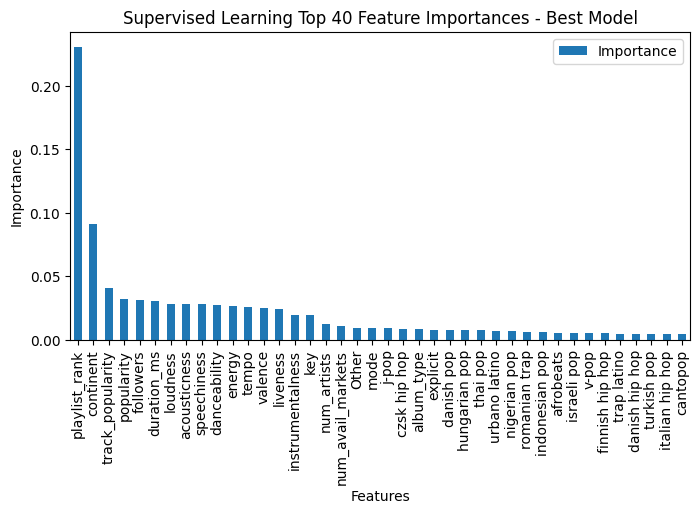

In [56]:
rf = df.copy()

X = rf.drop("market_id", axis=1)
y = rf["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Extract feature importances
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({"Features": features, "Importance": importances})

# Sort the features based on importance
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Plot the top N features
N = 40  # Change N to display more or fewer features
feature_df.head(N).plot(x="Features", y="Importance", kind="bar", figsize=(8, 4))
plt.title("Supervised Learning Top 40 Feature Importances - Best Model")
plt.ylabel("Importance")
plt.show()

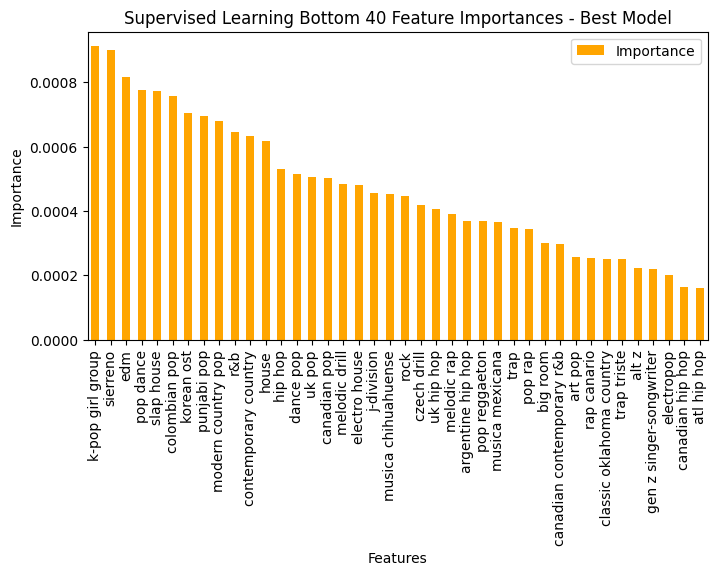

In [57]:
N = 40  # Change N to display more or fewer features
color = "orange"  # Set the bar color

feature_df.tail(N).plot(x="Features", y="Importance", kind="bar", figsize=(8, 4), color=color)
plt.title("Supervised Learning Bottom 40 Feature Importances - Best Model")
plt.ylabel("Importance")
plt.show()

In [58]:
# Testing how the number of features changes performance
feature_counts = [5, 10, 15, 20, 25]

for num_features in feature_counts:
    # Get the top 'num_features' features
    top_features = feature_df["Features"].head(num_features).tolist()

    # Filter dataset to use only the top 'num_features' features
    X_top_features = X[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

    # Model Selection and Training
    model_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
    model_top_features.fit(X_train, y_train)

    # Evaluation
    y_pred = model_top_features.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy using Random Forest Classifier with Top {num_features} Features: {accuracy * 100:.2f}%")

Accuracy using Random Forest Classifier with Top 5 Features: 28.25%
Accuracy using Random Forest Classifier with Top 10 Features: 27.89%
Accuracy using Random Forest Classifier with Top 15 Features: 26.67%
Accuracy using Random Forest Classifier with Top 20 Features: 29.65%
Accuracy using Random Forest Classifier with Top 25 Features: 30.53%


# Sensitivity Analysis

In [59]:
# Creating a version of the df used for modeling for this section
sa = artists.merge(tracks, on="artist_id")
sa = sa[sa["market_id"] != "global"]

sa["market_id"] = sa["market_id"].str.replace("_", " ").str.title()
sa["market_id"] = sa["market_id"].replace("Uae", "United Arab Emirates")
sa["market_id"] = sa["market_id"].replace("Usa", "United States")

sa["continent"] = sa["market_id"].apply(country_to_continent)
sa["feat"] = sa["track_name"].str.contains("feat").astype(int)


columns_to_drop_sa = [
    "artist_id",
    "track_id",
    "track_name",
    "playlist_id",
    "album_id",
    "artist_ids",
    "parent_genre",
    "tot_artist_followers",
    "avg_artist_popularity",
    "genres",
]


sa = sa.drop(columns=columns_to_drop_sa)

label_encoders = {}
for column in ["artist_name", "album_type", "continent", "key", "mode", "time_signature", "feat"]:
    le = LabelEncoder()
    sa[column] = le.fit_transform(sa[column])
    label_encoders[column] = le

# genre_counts_rfe = rfe_df['genres'].explode().value_counts()

# # Select the top 50 genres
# top_genres_rfe = genre_counts_rfe.head(100).index

# # Create a new DataFrame with the top 50 genres and an "Other" category
# df_top_genres_rfe = rfe_df.copy()
# df_top_genres_rfe['genres'] = rfe_df['genres'].apply(lambda x: [genre if genre in top_genres_rfe else 'Other' for genre in x])

# # Use MultiLabelBinarizer to one-hot encode the genres
# mlb = MultiLabelBinarizer()
# genres_encoded = pd.DataFrame(mlb.fit_transform(df_top_genres_rfe['genres']), columns=mlb.classes_, index=rfe_df.index)
# rfe_df = pd.concat([df_top_genres_rfe.drop('genres', axis=1), genres_encoded], axis=1)

### Testing sensitivity to features

In [60]:
# The model withouth genres drops to 28% accuracy
sa.fillna(value=0, inplace=True)
X = sa.drop("market_id", axis=1)
y = sa["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the GradientBoostingClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Gradient Boosting Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the Gradient Boosting model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Gradient Boosting Model: {accuracy * 100:.2f}%")

Classification Report for Gradient Boosting Model:
                      precision    recall  f1-score   support

           Argentina       0.50      0.44      0.47         9
           Australia       0.11      0.33      0.16         6
             Austria       0.00      0.00      0.00        13
             Belarus       0.47      0.57      0.52        14
             Belgium       0.00      0.00      0.00        12
              Brazil       0.78      0.70      0.74        10
              Canada       0.00      0.00      0.00        18
               Chile       0.38      0.33      0.35         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.15      0.25      0.19         8
             Denmark       0.32      0.60      0.41        10
  Dominican Republic       0.00      0.00      0.00         4
             Ecuador       0.00      0.00      0.00        12
               Egypt       0.64      0.88      0.74         8
             Finla

In [62]:
# The model withouth genres drops to 28% accuracy
sa_1 = df.copy()
sa_1 = sa_1.drop(columns=["playlist_rank", "continent", "track_popularity"])

X = sa_1.drop("market_id", axis=1)
y = sa_1["market_id"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (you may have already done this, but it's included here for clarity)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the GradientBoostingClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Gradient Boosting Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the Gradient Boosting model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Gradient Boosting Model: {accuracy * 100:.2f}%")

Classification Report for Gradient Boosting Model:
                      precision    recall  f1-score   support

           Argentina       0.71      0.56      0.63         9
           Australia       0.00      0.00      0.00         6
             Austria       0.00      0.00      0.00        13
             Belarus       0.50      0.71      0.59        14
             Belgium       0.00      0.00      0.00        12
              Brazil       0.90      0.90      0.90        10
              Canada       0.00      0.00      0.00        18
               Chile       0.57      0.44      0.50         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.27      0.50      0.35         8
             Denmark       0.50      0.70      0.58        10
  Dominican Republic       0.00      0.00      0.00         4
             Ecuador       0.00      0.00      0.00        12
               Egypt       0.75      0.75      0.75         8
             Finla

# Failure Analysis

In [63]:
# Define the hyperparameters and their possible values for a Random Forest model
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees in the forest
    "max_depth": [None, 10, 20],  # Maximum depth of the trees
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split an internal node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples required to be a leaf node
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, scoring="accuracy")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
print("Classification Report for Tuned Random Forest Model:")
print(classification_report(y_test, y_pred))

# Calculate accuracy for the tuned model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Tuned Random Forest Model: {accuracy * 100:.2f}%")

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Classification Report for Tuned Random Forest Model:
                      precision    recall  f1-score   support

           Argentina       0.42      0.56      0.48         9
           Australia       0.00      0.00      0.00         6
             Austria       0.00      0.00      0.00        13
             Belarus       0.52      0.79      0.63        14
             Belgium       0.00      0.00      0.00        12
              Brazil       0.90      0.90      0.90        10
              Canada       0.00      0.00      0.00        18
               Chile       0.75      0.33      0.46         9
            Colombia       0.00      0.00      0.00         6
      Czech Republic       0.45      0.62      0.53         8
             Denmark       1.00      0.70      0.82        10
  Dominican Republic       0.00      0.00      0.00         4
             Ecuador       0.00      0.00      0.00        12
               Egypt       0.60      0.75      0.67         8
             Fin

/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arturoavila/Library/Caches/pypoetry/virtualenvs/spotify-market-popularity-JDTflhsm-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and